<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#R-NGWD-OGWD" data-toc-modified-id="R-NGWD-OGWD-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>R-NGWD-OGWD</a></span><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data loading</a></span><ul class="toc-item"><li><span><a href="#Tropopause" data-toc-modified-id="Tropopause-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Tropopause</a></span></li></ul></li><li><span><a href="#Visualization---Figure-S1" data-toc-modified-id="Visualization---Figure-S1-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualization - Figure S1</a></span></li></ul></li><li><span><a href="#R-tnmmuphy" data-toc-modified-id="R-tnmmuphy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>R-tnmmuphy</a></span><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Visualization</a></span></li></ul></li></ul></div>

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import shapely.geometry as sgeom
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import glob

%matplotlib inline

In [1]:
%reload_ext watermark
%watermark --iversions -v -m

CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-122-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [4]:
DJF_bool = '_DJFonly'
cesta = '/mnt/4data/CMAM/0A.daily/composites_woSSW{}/'.format(DJF_bool)
e_type_ls = ['himalayas', 'eastasia', 'westamer']
mpl.rcParams.update({'font.size': 18})

what = 'anomalies'
timescale = 20

# R-NGWD-OGWD

## Data loading

### Tropopause

In [6]:
infile_name = '{}{}_{}_comp_*_{}days.nc'.format(cesta, 'ptrop', 'absolute', 20)
infiles = glob.glob(infile_name)
e_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
da_trop =  xr.open_mfdataset(infiles, concat_dim='e_type', combine='nested')
da_trop['e_type'] = e_types
da_trop['ptrop'] = da_trop.ptrop/100.#da_trop

In [7]:
var = 'TEM-res3-new'
what_ls = ['anomalies']#, 'absolute']
da_ls2 = []

for what in what_ls:
    da_ls = []
    #print(what)
    for i,e_type in enumerate(e_type_ls):
        #print(e_type)
        da = xr.open_dataarray('{}{}_{}_comp_{}_{}days.nc'.format(cesta, var, what, e_type, timescale))
        if var != 'lwa':
            da['plev'] = da.plev/100.
        else:
            da = da.rename({'z': 'plev'})

        da_ls.append(da)
    da_conc = xr.concat(da_ls, dim = 'e_type')
    da_conc['e_type'] = e_type_ls
    da_ls2.append(da_conc)
        
da_all = xr.concat(da_ls2, dim = 'what')
da_all['what'] = what_ls

## Visualization - Figure S1

TEM-res2-new_anomalies_all_20days_zm_wosignificance_DJFonly.pdf


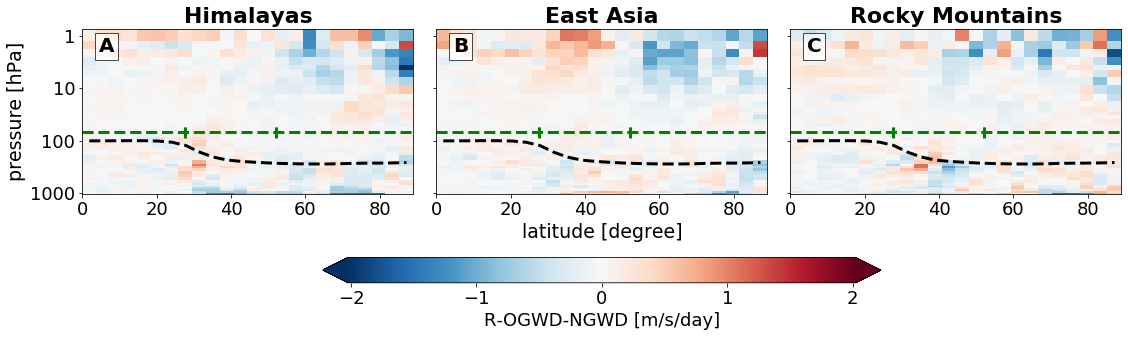

In [30]:
ticks = [-7,-5,-3,-2,-1,0,1,2,3,5,7]
clabel = 'R-OGWD-NGWD [m/s/day]'
cbar_dict = dict(orientation="horizontal", spacing='proportional', extend='both', label = clabel, \
                 fraction=.1, ticks = ticks, pad = 0.25)
sel_dict = dict(lag = 0, \
            plev = slice(None,1), \
            lat = slice(0,None))

cmap = mpl.cm.RdBu_r
p = (da_all.sel(**sel_dict)*24*3600).plot(col = 'e_type', \
                                                yincrease = False,
                                                size =5, cmap = cmap, 
                                                cbar_kwargs=cbar_dict)

label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
titles = ['Himalayas', 'East Asia', 'Rocky Mountains']# 'West America']
for i, (ax, label) in enumerate(zip(p.axes.flatten(), label_ls)):
    ax.set_title(titles[i], fontdict=dict(fontweight = 'bold', fontsize = 22))
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize = 20, 
              fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
    if i == 0:
        ax.set_ylabel('pressure [hPa]', fontdict=dict(fontsize = 19))
        
    if i == 1:
        ax.set_xlabel('latitude [degree]', fontdict=dict(fontsize = 19))
    else:
        ax.set_xlabel('')
    
    ax.hlines(70,0,90, color = 'green', linestyles='--', linewidths = 3)
    if e_type == 'himalayas':
        box = sgeom.box(minx=70, maxx=105, miny=20, maxy=40)
    elif e_type == 'eastasia':
        box = sgeom.box(minx=110, maxx=145, miny=30, maxy=48)
    elif e_type == 'westamer':
        box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    ax.vlines(list(box.bounds)[1::2],90,50, color = 'green', linestyles='--', linewidths = 3)
    
    da_trop2 = da_trop.ptrop.sel(lag=0, lat = slice(0,None)).mean('lon')
    lat = da_trop2.lat.values
    ax.plot(lat, da_trop2.sel(e_type = e_type), 'k--', lw = 3)
    
    #ax.axis([0, 90, 1000, 1])
    ax.set_yscale('log')
    ax.set_yticks([1000,100,10,1])
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xticks([0,20,40,60,80])

outfile='{}_{}_{}_{}days_zm_wosignificance_DJFonly.pdf'.format(var, what_ls[0], 'all', timescale)
print(outfile)
plt.savefig(outfile, dpi = 300, bbox_inches='tight')

In [22]:
cmap = p.cbar.cmap.name
vmax = p.cbar.vmax
vmin = p.cbar.vmin
print(f'vmax: {vmax}')

vmax: 2.802423361817999


# R-tnmmuphy

## Data loading

In [23]:
var = 'TEM-res2-new'
what_ls = ['anomalies']#, 'absolute']
da_ls2 = []

for what in what_ls:
    da_ls = []
    #print(what)
    for i,e_type in enumerate(e_type_ls):
        #print(e_type)
        da = xr.open_dataarray('{}{}_{}_comp_{}_{}days.nc'.format(cesta, var, what, e_type, timescale))
        if var != 'lwa':
            da['plev'] = da.plev/100.
        else:
            da = da.rename({'z': 'plev'})

        da_ls.append(da)
    da_conc = xr.concat(da_ls, dim = 'e_type')
    da_conc['e_type'] = e_type_ls
    da_ls2.append(da_conc)
        
da_all = xr.concat(da_ls2, dim = 'what')
da_all['what'] = what_ls

## Visualization

TEM-res2-new_anomalies_all_20days_zm_wosignificance_DJFonly.pdf


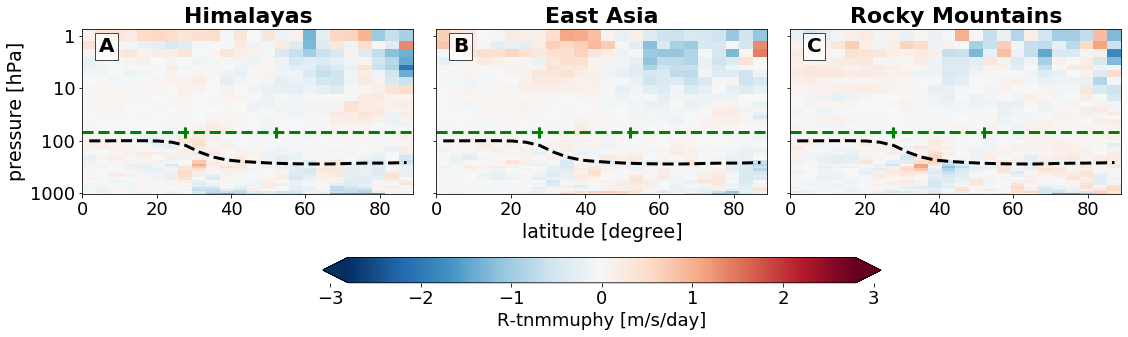

In [31]:
clabel = 'R-tnmmuphy [m/s/day]'
cbar_dict = dict(orientation="horizontal", spacing='proportional', extend='both', label = clabel, \
                 fraction=.1, ticks = ticks, pad = 0.25)
p = (da_all.sel(**sel_dict)*24*3600).plot(col = 'e_type', cmap = cmap,\
                                                yincrease = False,
                                                 size =5, vmax = vmax, vmin = vmin,
                                                cbar_kwargs=cbar_dict)
for i, (ax, label) in enumerate(zip(p.axes.flatten(), label_ls)):
    ax.set_title(titles[i], fontdict=dict(fontweight = 'bold', fontsize = 22))
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize = 20, 
              fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
    if i == 0:
        ax.set_ylabel('pressure [hPa]', fontdict=dict(fontsize = 19))
        
    if i == 1:
        ax.set_xlabel('latitude [degree]', fontdict=dict(fontsize = 19))
    else:
        ax.set_xlabel('')
    
    ax.hlines(70,0,90, color = 'green', linestyles='--', linewidths = 3)
    if e_type == 'himalayas':
        box = sgeom.box(minx=70, maxx=105, miny=20, maxy=40)
    elif e_type == 'eastasia':
        box = sgeom.box(minx=110, maxx=145, miny=30, maxy=48)
    elif e_type == 'westamer':
        box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    ax.vlines(list(box.bounds)[1::2],90,50, color = 'green', linestyles='--',  linewidths = 3)
    
    da_trop2 = da_trop.ptrop.sel(lag=0, lat = slice(0,None)).mean('lon')
    lat = da_trop2.lat.values
    ax.plot(lat, da_trop2.sel(e_type = e_type), 'k--', lw = 3)
    
    ax.set_yscale('log')
    ax.set_yticks([1000,100,10,1])
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xticks([0,20,40,60,80])
    
outfile='{}_{}_{}_{}days_zm_wosignificance_DJFonly.pdf'.format(var, what_ls[0], 'all', timescale)
print(outfile)
plt.savefig(outfile, dpi = 300, bbox_inches='tight')